In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import jax.numpy as np

import numpy as onp

import inspect
import os
import sys
import time

onp.random.seed(3452453)

In [2]:
from bnpgmm_runjingdev import genomics_data_utils

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
import gmm_plotting_utils

# Load data

In [4]:
# Set bnp_data_repo to be the location of a clone of the repo
# https://github.com/NelleV/genomic_time_series_bnp
bnp_data_repo = '../../../genomic_time_series_bnp' 

genome_data, timepoints, gamma, gamma_info, regressors_transformed = \
    genomics_data_utils.load_and_tranform_data(bnp_data_repo)

Loading data from:  ../../../genomic_time_series_bnp/data/shoemaker2015reprocessed


In [5]:
n_genes = genome_data.shape[0]
reg_dim = gamma.shape[1]

### Plot data and predictions 

In red are predictions by the transformed regression coefficients

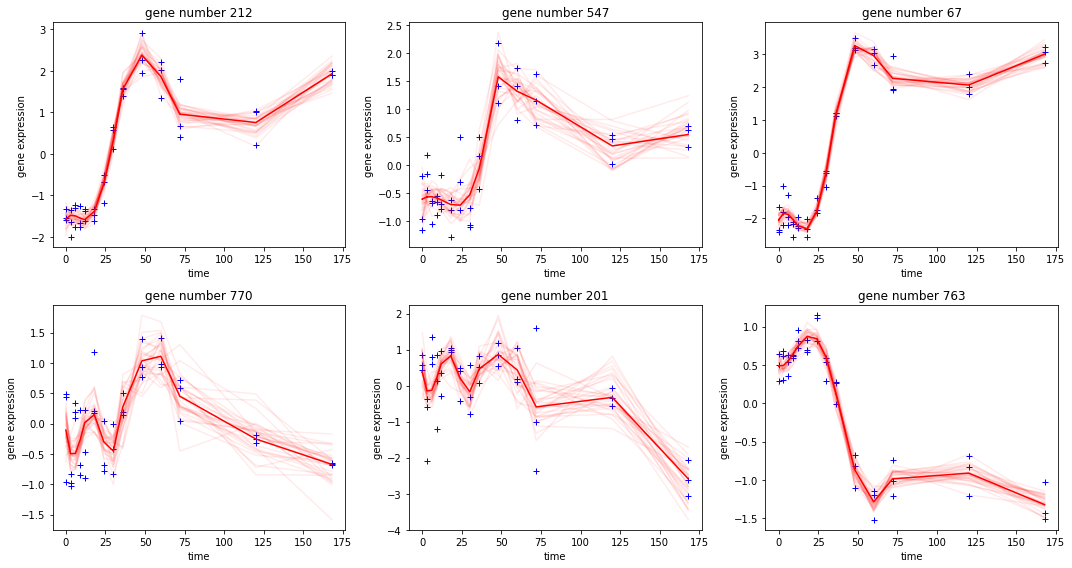

In [6]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

for i in range(6):
    gene_indx = onp.random.choice(n_genes, 6)
    n = gene_indx[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3]
    
    gmm_plotting_utils.PlotRegressionLine(y = genome_data - genome_data.mean(1)[:, None], 
                                          timepoints = timepoints,
                                          x = regressors_transformed,
                                          beta = gamma, 
                                          beta_info = gamma_info,
                                          n = n,
                                          ax = this_plot)
    
f.tight_layout()


### The gammas are what we will cluster

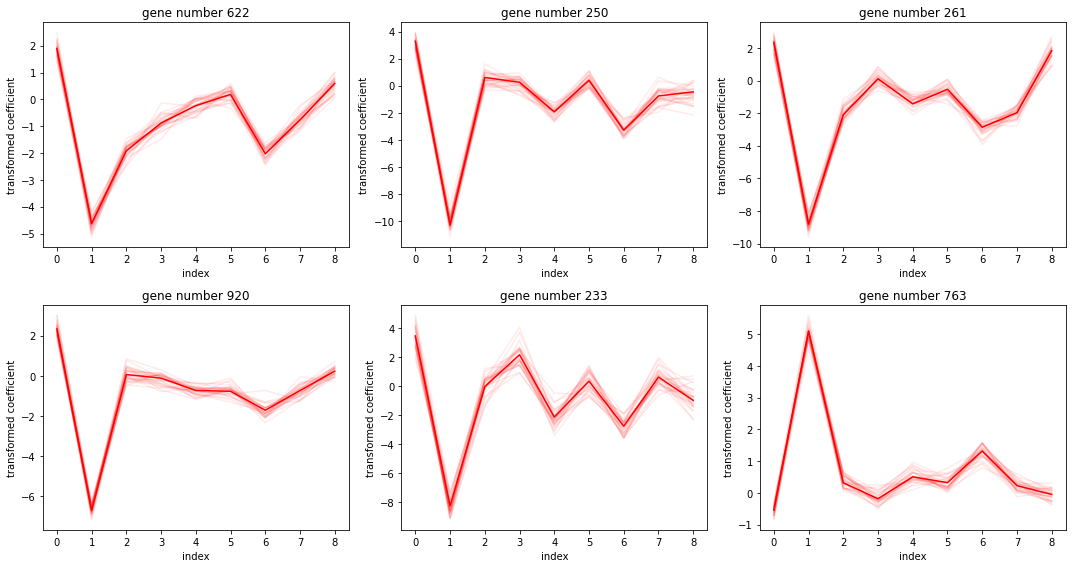

In [7]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

for i in range(6):
    n = gene_indx[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3] 
    this_plot.plot(gamma[n, :], color = 'red');
    this_plot.set_ylabel('transformed coefficient')
    this_plot.set_xlabel('index')
    this_plot.set_title('gene number {}'.format(n))

    # draw from the variational distribution, to plot uncertainties
    for j in range(30): 
        transformed_gamma_draw = onp.random.multivariate_normal(
            gamma[n, :], \
             np.linalg.inv(gamma_info[n]))

        axarr[int(np.floor(i / 3)), i % 3].plot(transformed_gamma_draw, 
                                                color = 'red', alpha = 0.08);

f.tight_layout()
